# Import modules

In [24]:
import pandas as pd
import numpy as np

import time, warnings
import datetime as dt

#modules for predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.mixture import GMM

from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

# Get the Data

In [25]:
#load the dataset
retail_df = pd.read_csv("Country-data.csv")
retail_df = retail_df.drop('country',axis=1)
retail_df['exports'] = retail_df['exports']*retail_df['gdpp']/100
retail_df['imports'] = retail_df['imports']*retail_df['gdpp']/100
retail_df['health'] = retail_df['health']*retail_df['gdpp']/100
retail_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### Preprocess Data

#### Feature correlations

In [26]:
rfm_data= retail_df

In [27]:
rfm_data.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.297230,-0.430438,-0.319138,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.297230,1.000000,0.612919,0.987686,0.725351,-0.141553,0.377694,-0.291096,0.768894
health,-0.430438,0.612919,1.000000,0.638581,0.690857,-0.253956,0.545626,-0.407984,0.916593
imports,-0.319138,0.987686,0.638581,1.000000,0.672056,-0.179458,0.397515,-0.317061,0.755114
income,-0.524315,0.725351,0.690857,0.672056,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.141553,-0.253956,-0.179458,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.377694,0.545626,0.397515,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.291096,-0.407984,-0.317061,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.768894,0.916593,0.755114,0.895571,-0.221631,0.600089,-0.454910,1.000000


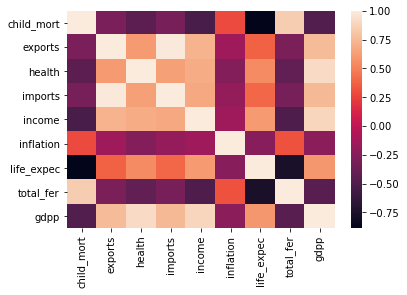

In [28]:
sns.heatmap(rfm_data.corr())

#### Visualize feature distributions

To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data. 

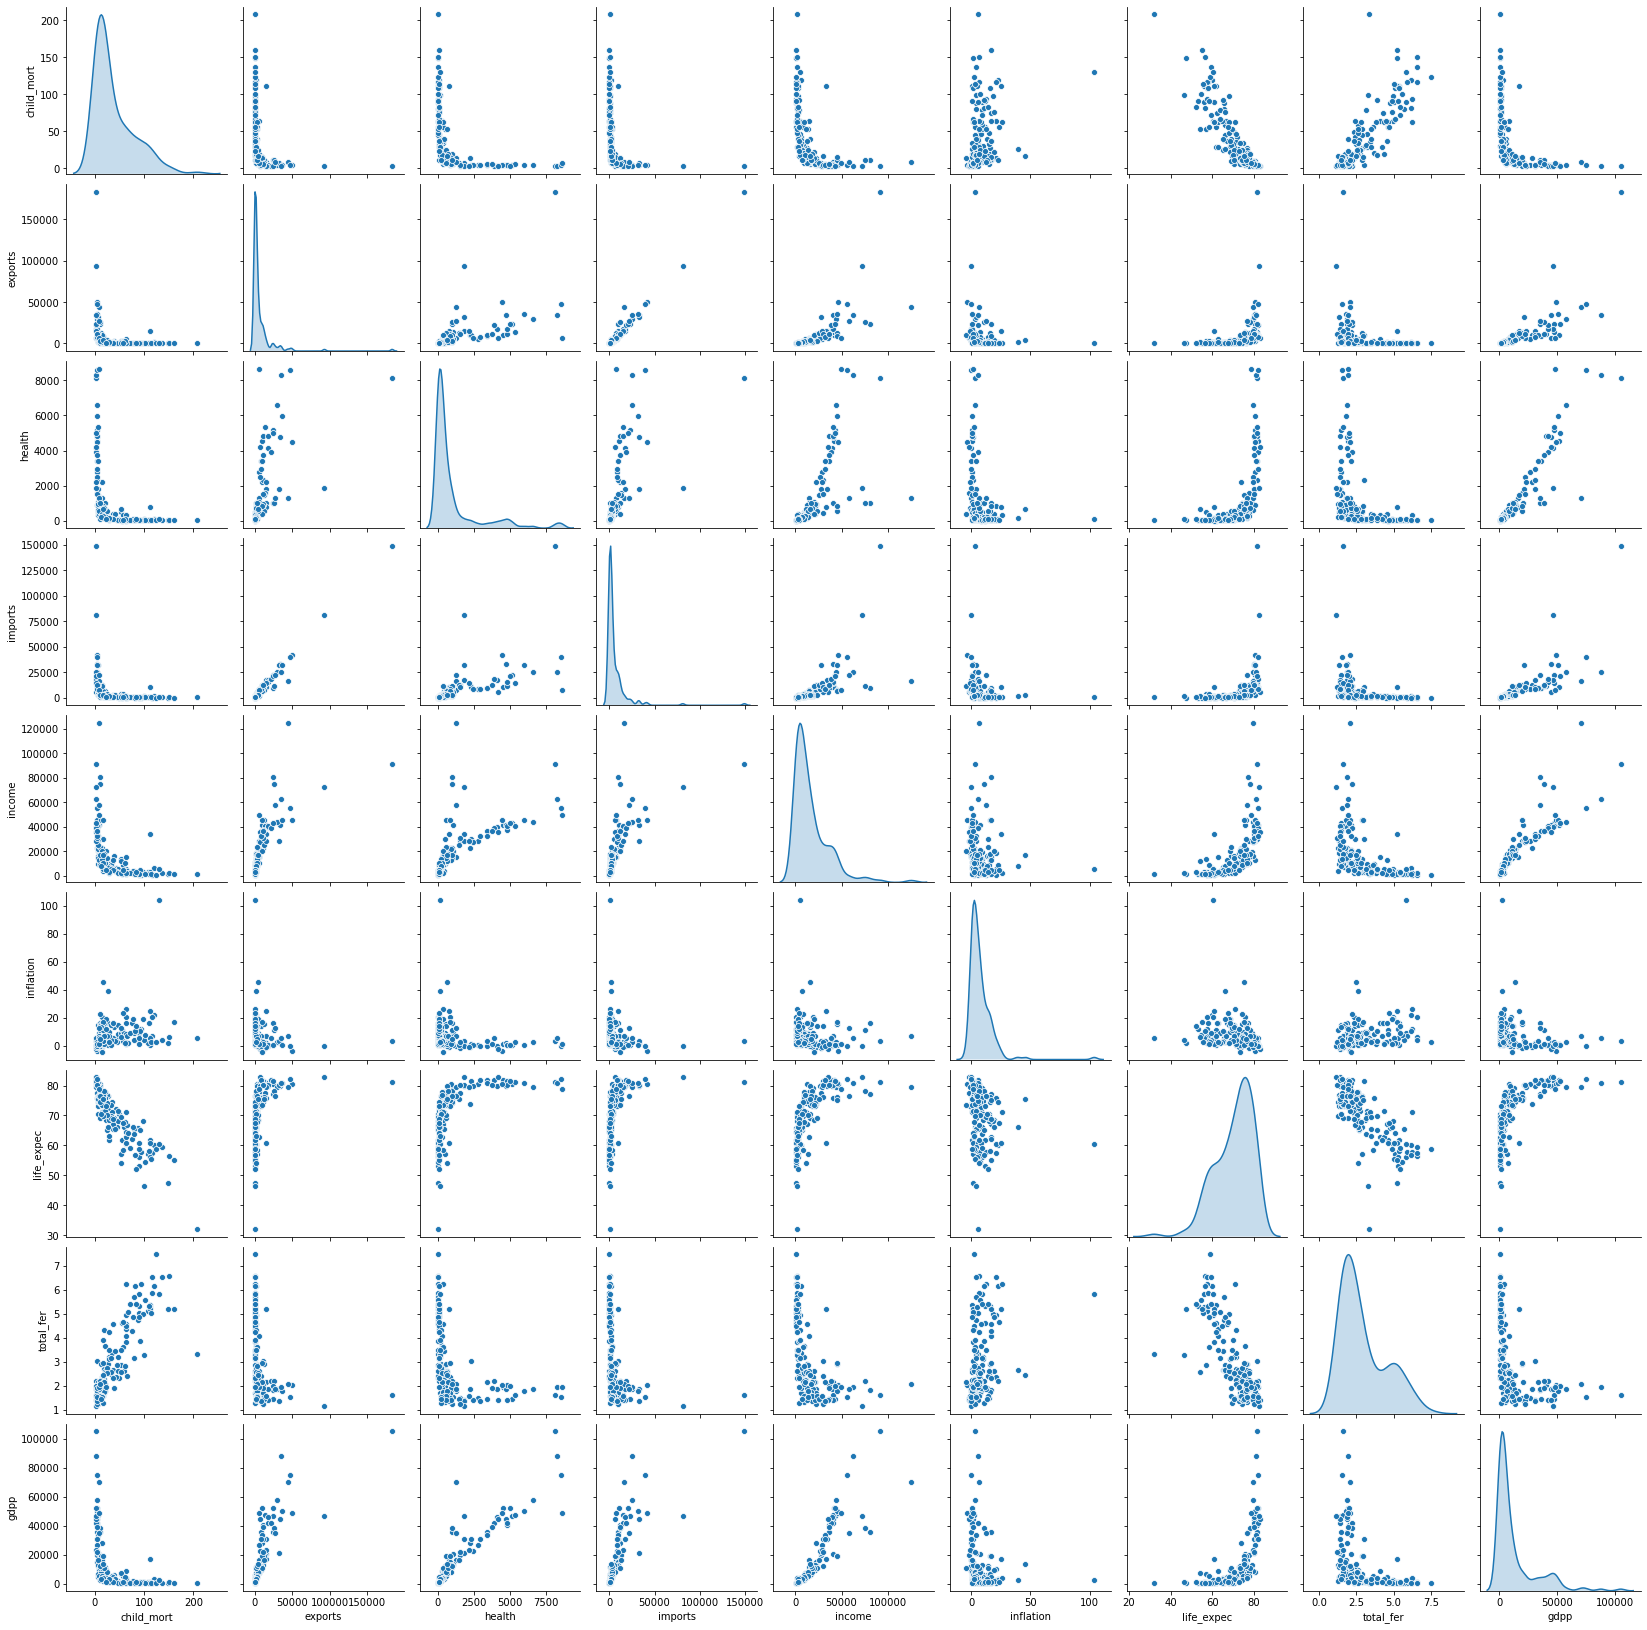

In [29]:
import seaborn as sns
sns.pairplot(rfm_data,diag_kind='kde')

In [30]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
log_data = pd.DataFrame(pt.fit_transform(rfm_data))
log_data.columns= rfm_data.columns

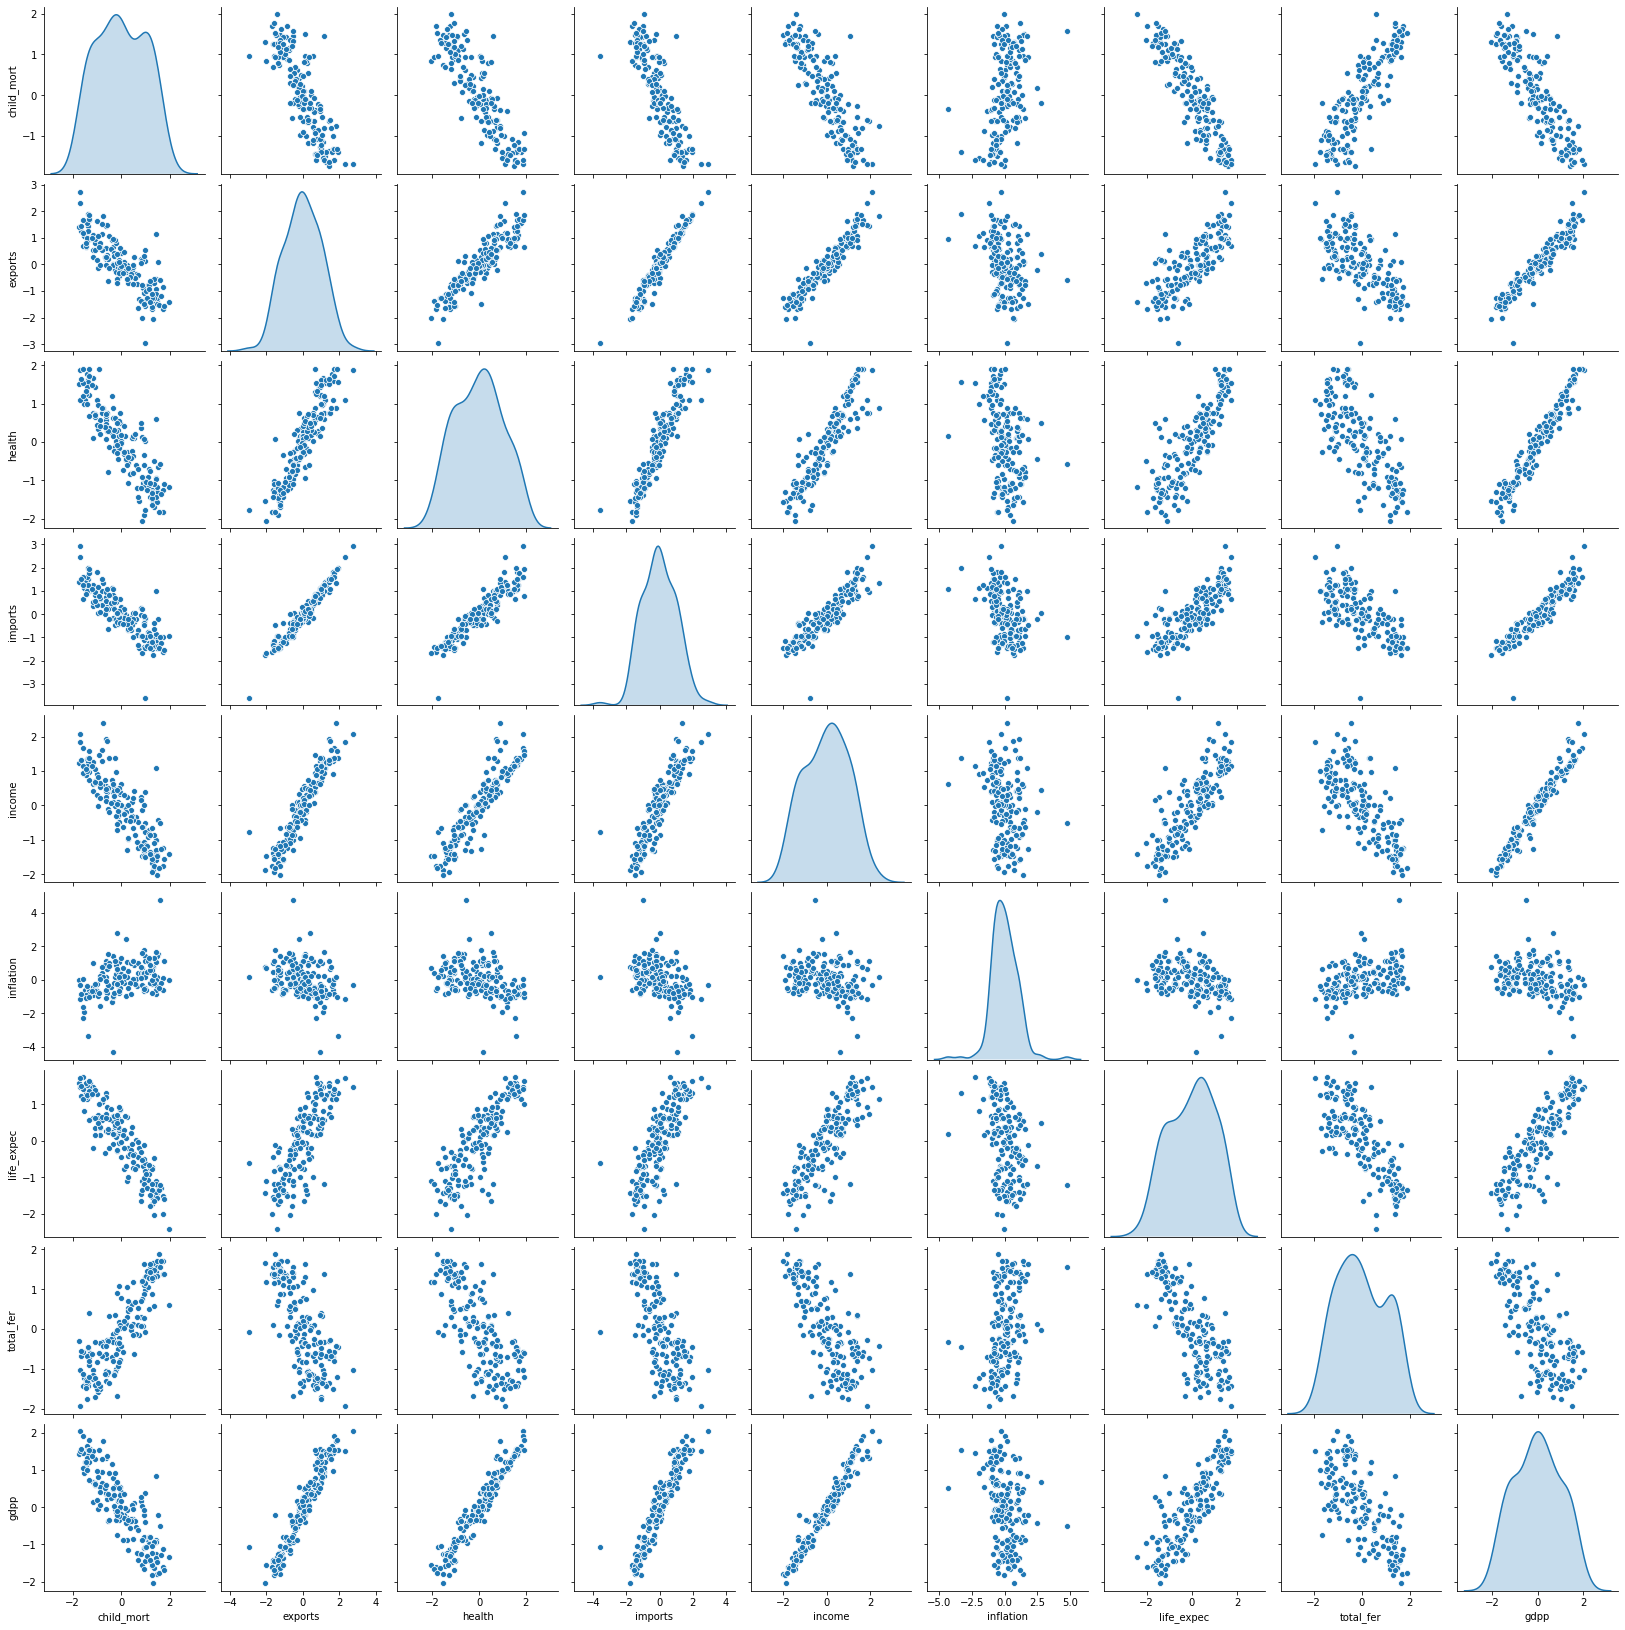

In [31]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(log_data,diag_kind='kde')

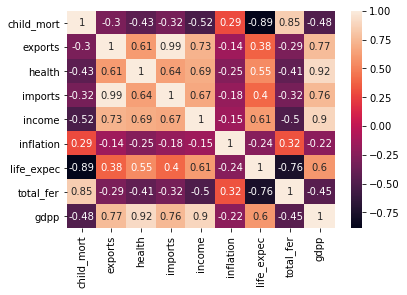

In [34]:
sns.heatmap(rfm_data.corr(),annot=True)

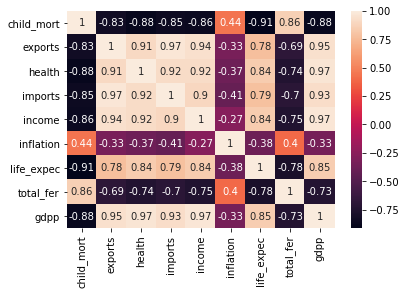

In [35]:
sns.heatmap(log_data.corr(),annot=True)

In [36]:
log_data.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.828179,-0.881659,-0.852726,-0.858146,0.441530,-0.913226,0.864808,-0.875812
exports,-0.828179,1.000000,0.907956,0.972217,0.940981,-0.330282,0.776561,-0.686132,0.945373
health,-0.881659,0.907956,1.000000,0.923833,0.918039,-0.373798,0.837782,-0.735039,0.969342
imports,-0.852726,0.972217,0.923833,1.000000,0.902035,-0.411520,0.788392,-0.699550,0.932625
income,-0.858146,0.940981,0.918039,0.902035,1.000000,-0.267740,0.838381,-0.746061,0.974392
inflation,0.441530,-0.330282,-0.373798,-0.411520,-0.267740,1.000000,-0.376364,0.397479,-0.333937
life_expec,-0.913226,0.776561,0.837782,0.788392,0.838381,-0.376364,1.000000,-0.782327,0.849122
total_fer,0.864808,-0.686132,-0.735039,-0.699550,-0.746061,0.397479,-0.782327,1.000000,-0.729164
gdpp,-0.875812,0.945373,0.969342,0.932625,0.974392,-0.333937,0.849122,-0.729164,1.000000


In [37]:
log_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-2.566144e-16,2.114077e-16,1.755083e-16,2.692457e-16,6.581562e-17,-1.196648e-16,1.608826e-16,2.459776e-16,-4.088546e-16
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-1.744350e+00,-2.970365e+00,-2.042388e+00,-3.587547e+00,-2.011864e+00,-4.317213e+00,-2.416375e+00,-1.930129e+00,-2.048077e+00
25%,-8.284494e-01,-7.061338e-01,-8.233392e-01,-7.232831e-01,-8.409075e-01,-6.380843e-01,-7.685230e-01,-7.821480e-01,-8.736345e-01
50%,-8.831974e-02,-1.139286e-02,6.971540e-02,-3.762465e-02,1.503946e-02,-2.446480e-02,1.556977e-01,-8.277119e-02,-3.385170e-02
75%,9.414307e-01,7.528821e-01,7.274778e-01,8.052977e-01,7.304487e-01,5.918641e-01,6.995533e-01,8.895016e-01,7.029404e-01
max,1.983013e+00,2.745091e+00,1.908333e+00,2.940514e+00,2.395485e+00,4.762676e+00,1.746675e+00,1.873128e+00,2.042503e+00


### K-means Implementation

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The [elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) method can be used to determine the number of clusters as well.

**Note:** K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called ***k-means++***.

In [38]:
X=log_data

In [39]:
from sklearn.cluster import KMeans
# Let us check optimal number of clusters-
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(X)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10]

,num_clusters,cluster_errors
0,1,1503.000000
1,2,650.272277
2,3,418.810059
3,4,364.853287
4,5,326.424231
5,6,295.866871
6,7,272.856040
7,8,252.504214
8,9,236.740115
9,10,224.203489


In [40]:
errors = clusters_df['cluster_errors']

In [41]:
for i in range(8):
    print(errors[i+1]-errors[i])

-852.7277225615843
-231.46221858601223
-53.95677167574769
-38.42905662508559
-30.557359112980123
-23.010831047652516
-20.351825990363466
-15.764099135679771


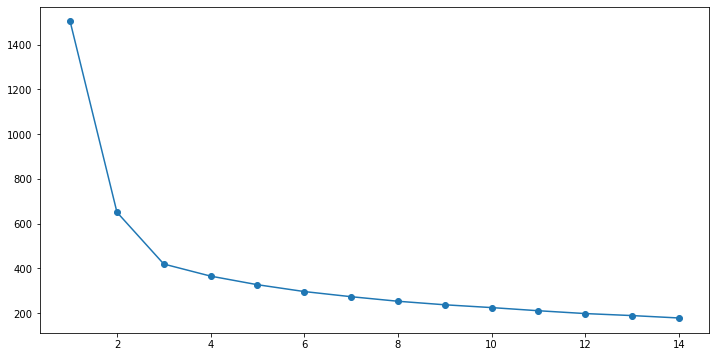

In [42]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [43]:
# Number of clusters
kmeans = KMeans(n_clusters=3,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_
# Comparing with scikit-learn centroids
print("Centroid values")
print("sklearn")
print(centroids) # From sci-kit learn

Centroid values
sklearn
[[ 1.17330507 -1.14975736 -1.17619414 -1.13618535 -1.20962975  0.43422925
  -1.12302598  1.13631868 -1.19390869]
 [-0.04128765  0.03358007  0.03112836 -0.00248561  0.09416955  0.23550992
   0.07353174 -0.18750883  0.03708553]
 [-1.18670464  1.17313325  1.20490898  1.21240979  1.14658763 -0.81270547
   1.08519313 -0.92958118  1.21488186]]


In [44]:
prediction= kmeans.predict(X)
#X["clusters"] = prediction
X_df = pd.DataFrame(X, columns= log_data.columns)
X_df["group"] = prediction

In [45]:
X_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,group
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2


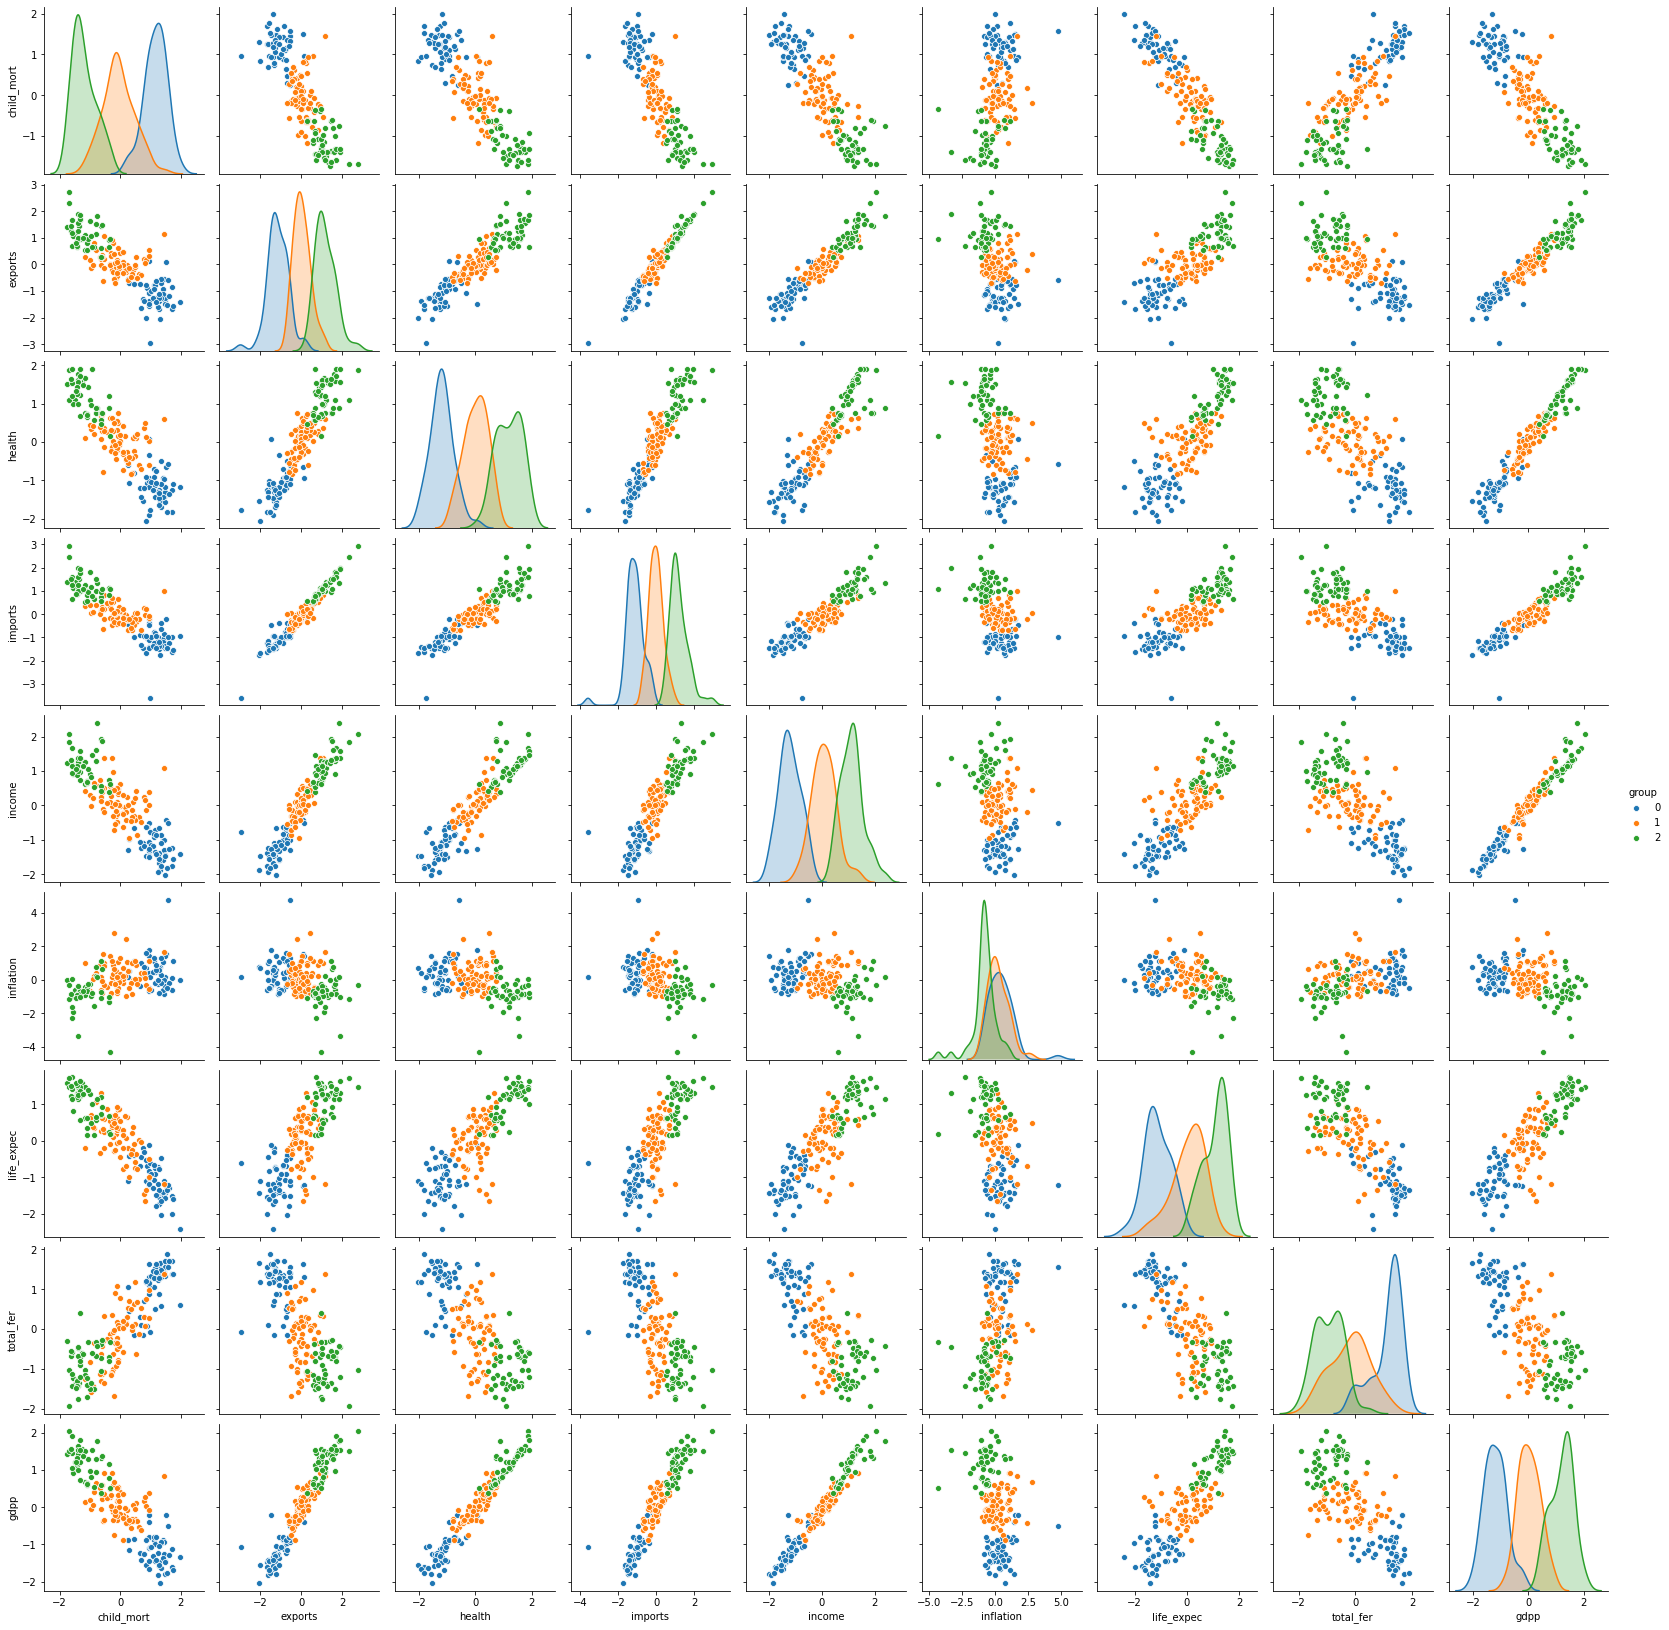

In [46]:
sns.pairplot(X_df,diag_kind='kde',hue='group')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017281B0F7C0>,
      dtype=object)

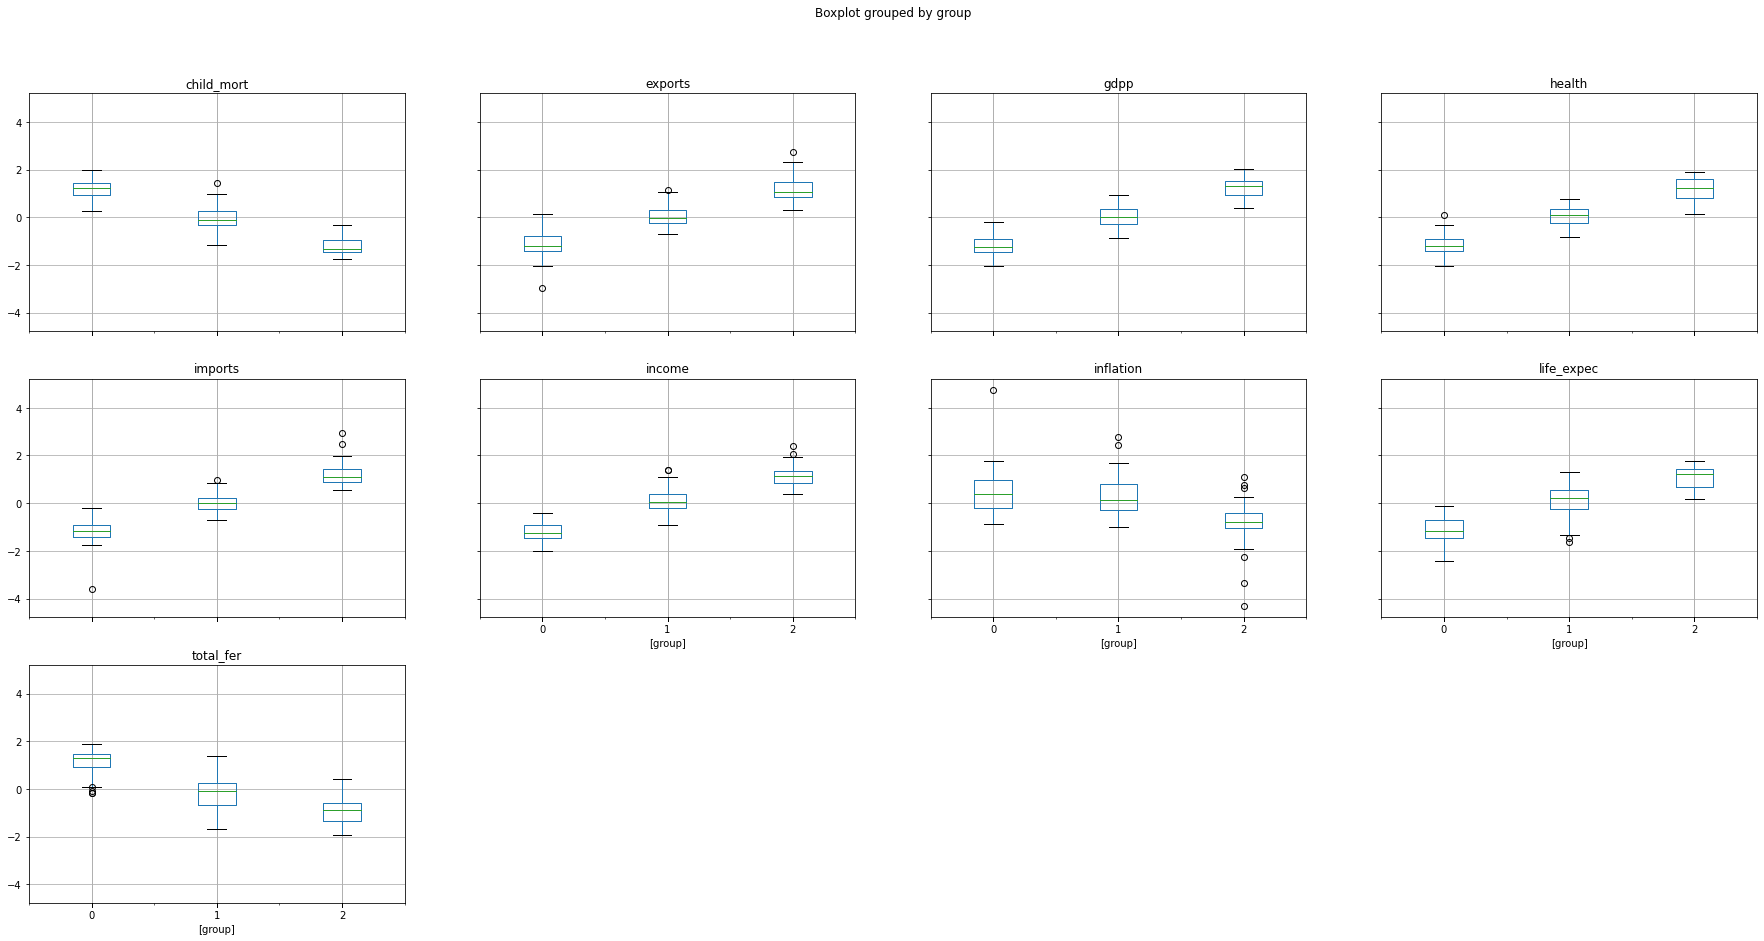

In [49]:
X_df.boxplot(by = 'group',layout=(3,4), figsize=(30, 15))

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.44351069200040283


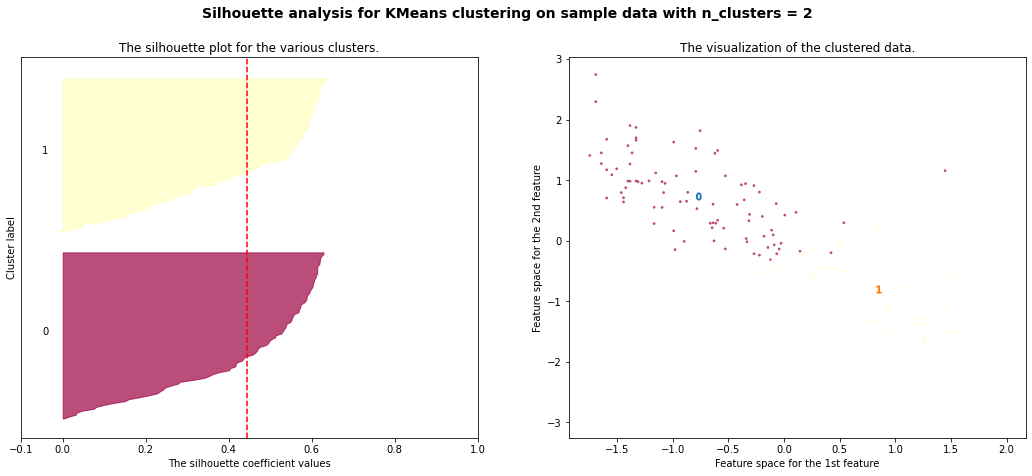

For n_clusters = 3 The average silhouette_score is : 0.3970904804043125


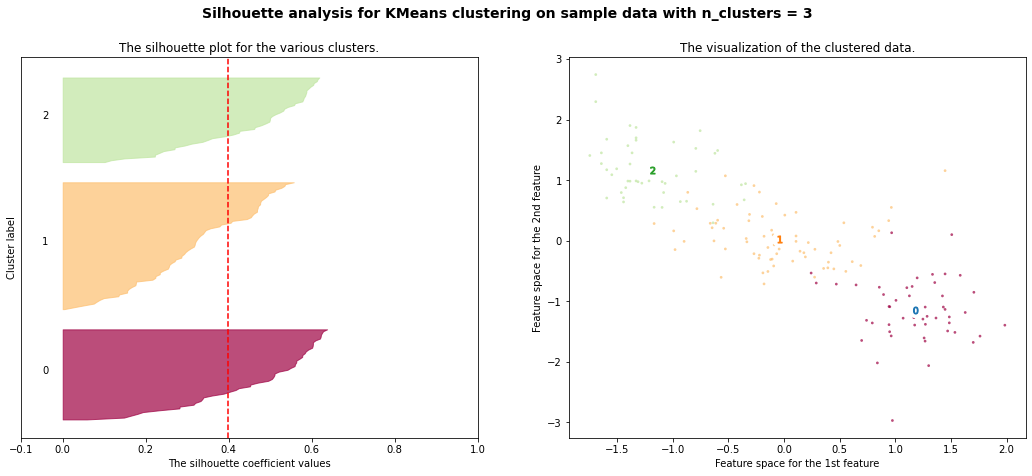

For n_clusters = 4 The average silhouette_score is : 0.3104781292126795


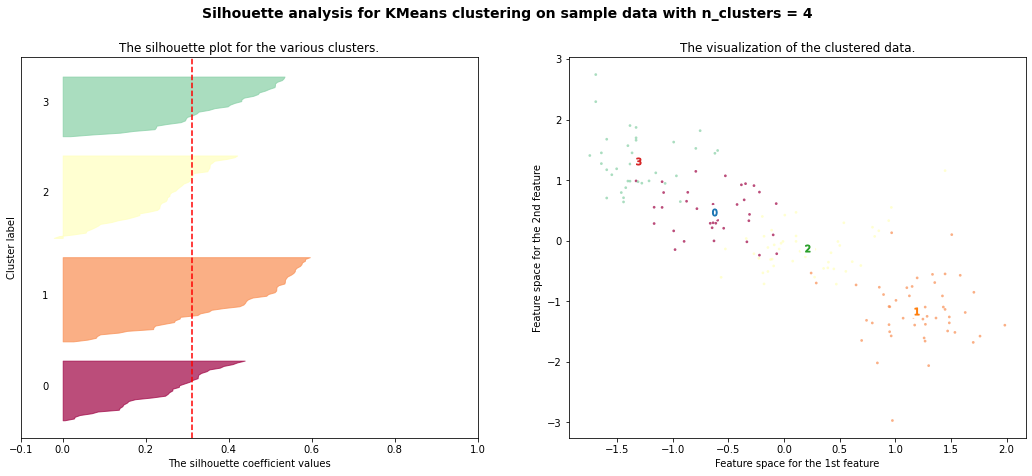

For n_clusters = 5 The average silhouette_score is : 0.3090077515068151


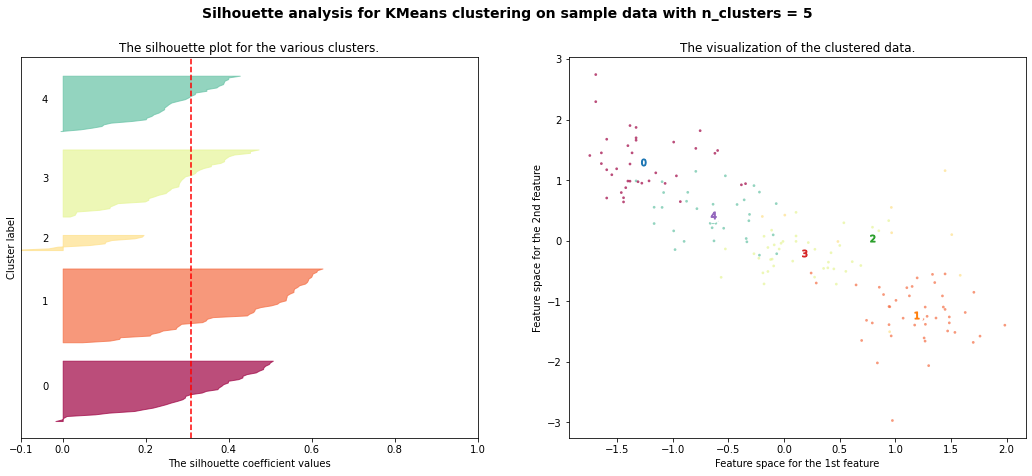

For n_clusters = 6 The average silhouette_score is : 0.3120108582614187


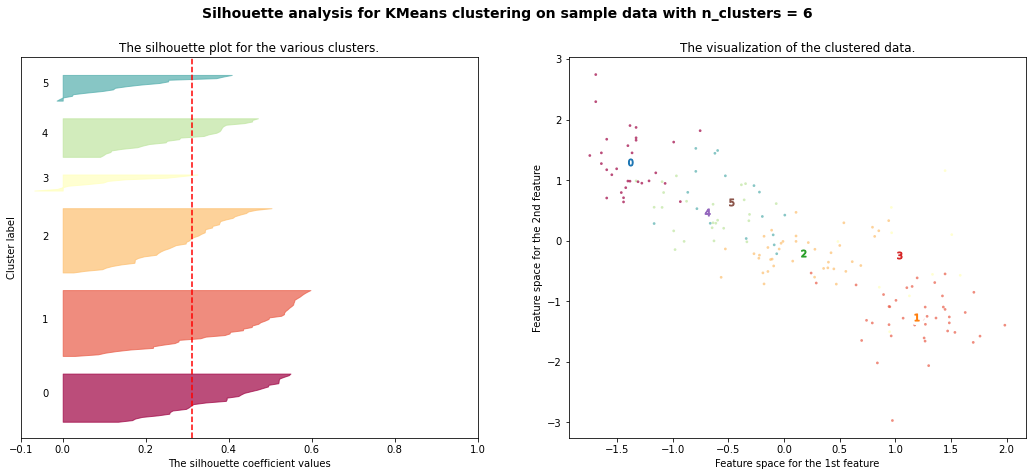

For n_clusters = 7 The average silhouette_score is : 0.27443933381389635


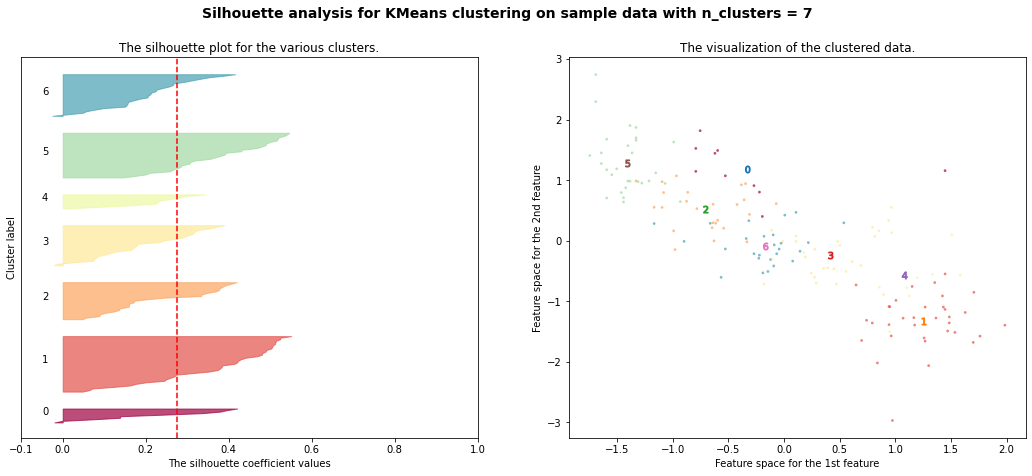

For n_clusters = 8 The average silhouette_score is : 0.25112011661694916


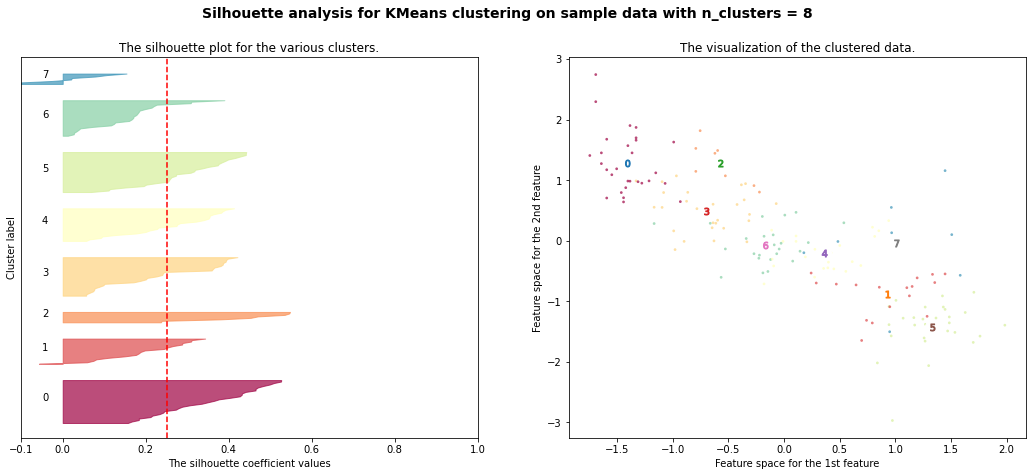

For n_clusters = 9 The average silhouette_score is : 0.2709975022065259


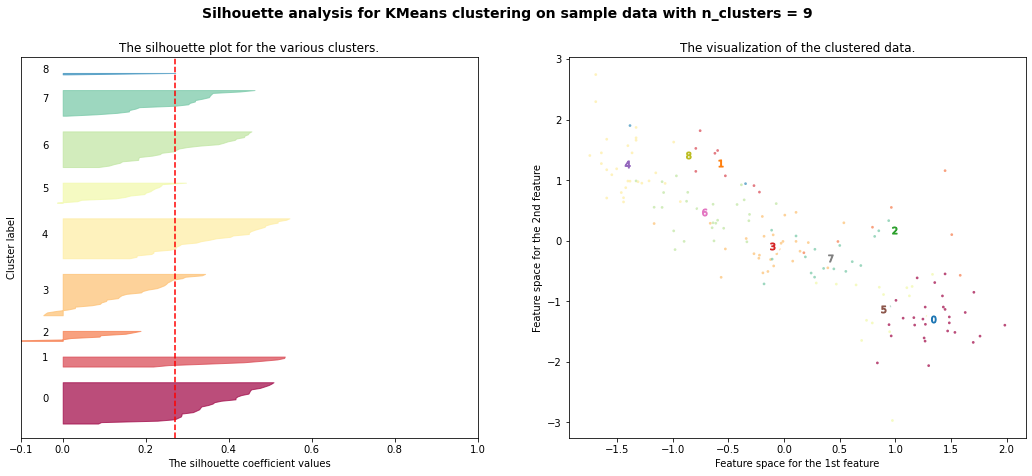

For n_clusters = 10 The average silhouette_score is : 0.26314185483483815


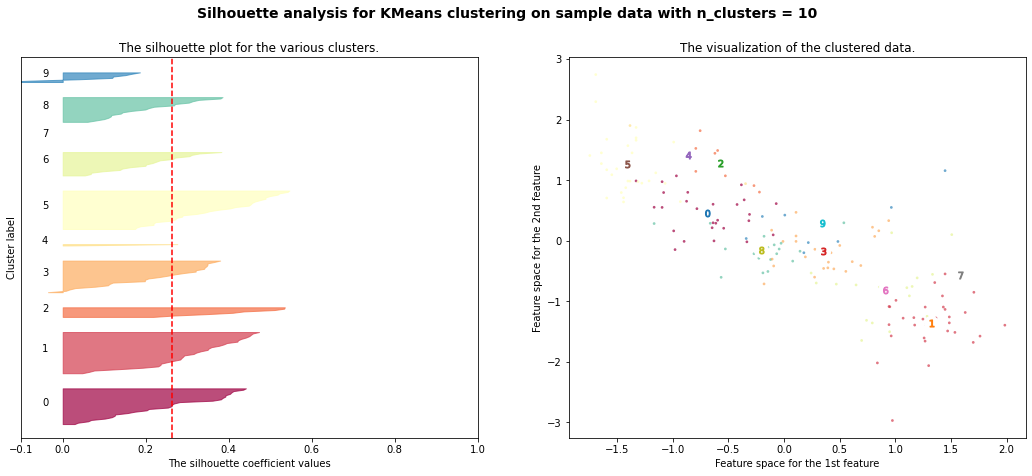

For n_clusters = 11 The average silhouette_score is : 0.2449106230144222


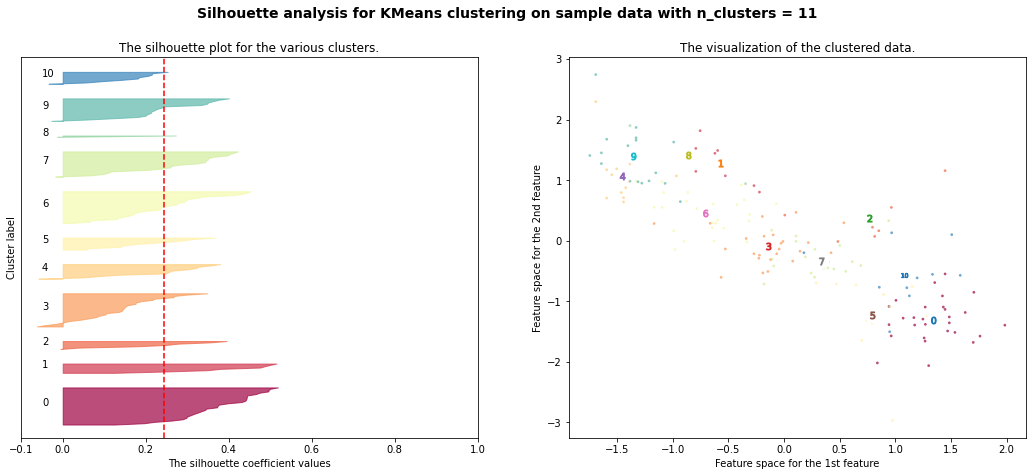

For n_clusters = 12 The average silhouette_score is : 0.22558303153889184


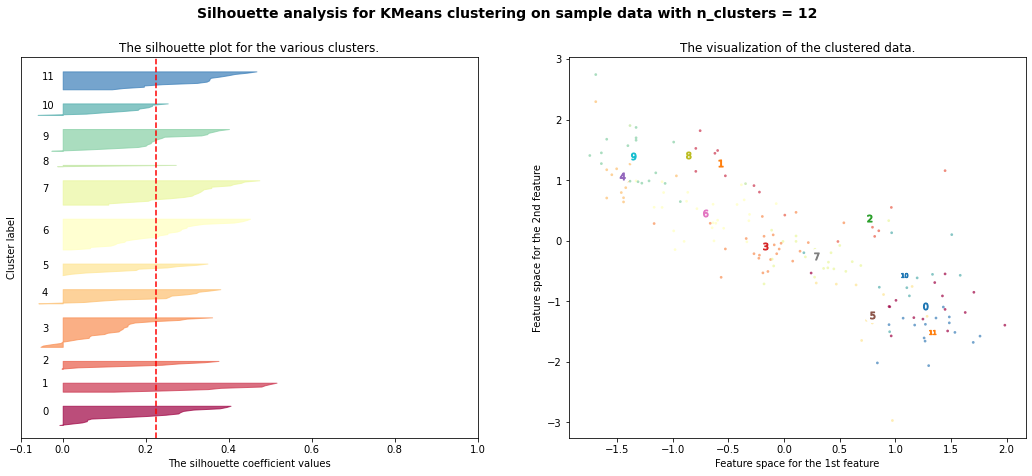

For n_clusters = 13 The average silhouette_score is : 0.2130052321529385


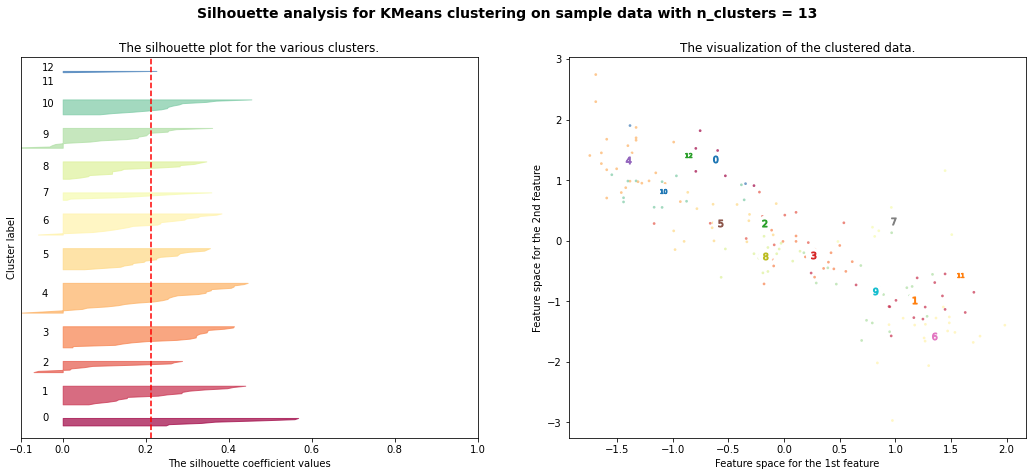

For n_clusters = 14 The average silhouette_score is : 0.21669976156659917


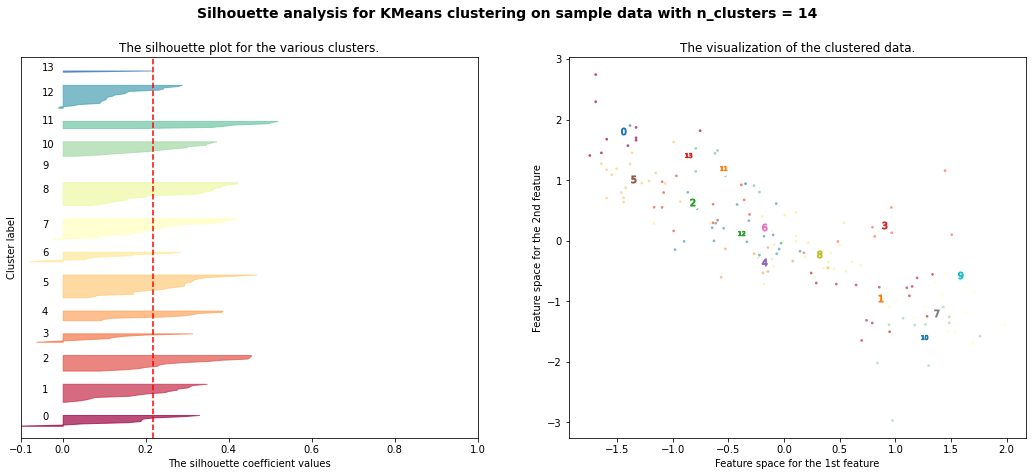

For n_clusters = 15 The average silhouette_score is : 0.22592924046292073


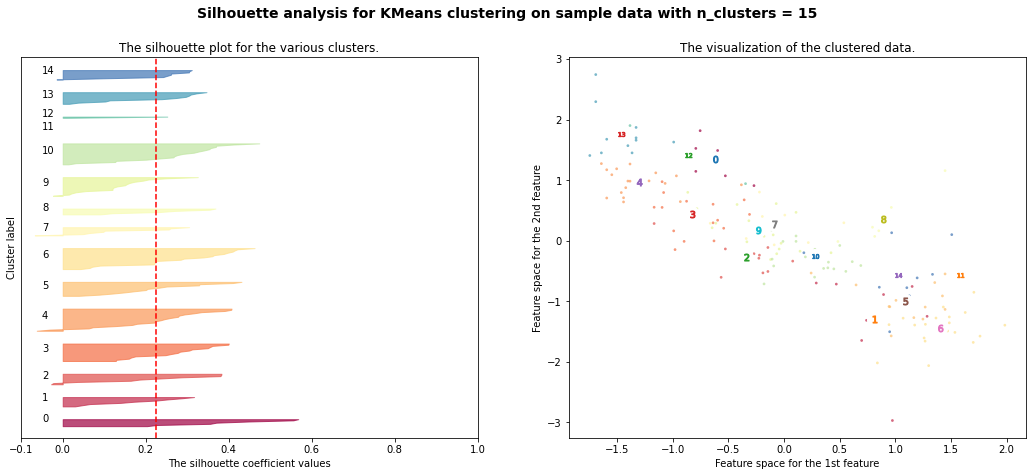

For n_clusters = 16 The average silhouette_score is : 0.21514790363091


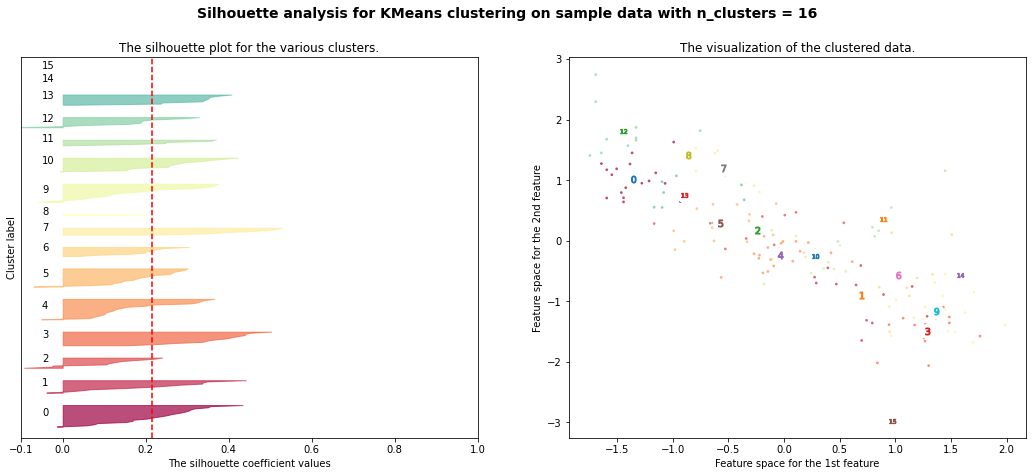

In [50]:
from __future__ import print_function
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X=X_df.drop('group',axis=1).values
y=X_df['group'].values

range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,n_init = 100,init='k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [51]:
from sklearn.cluster import AgglomerativeClustering 

In [52]:
model2 = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')

In [53]:
model2.fit(X)

AgglomerativeClustering(n_clusters=3)

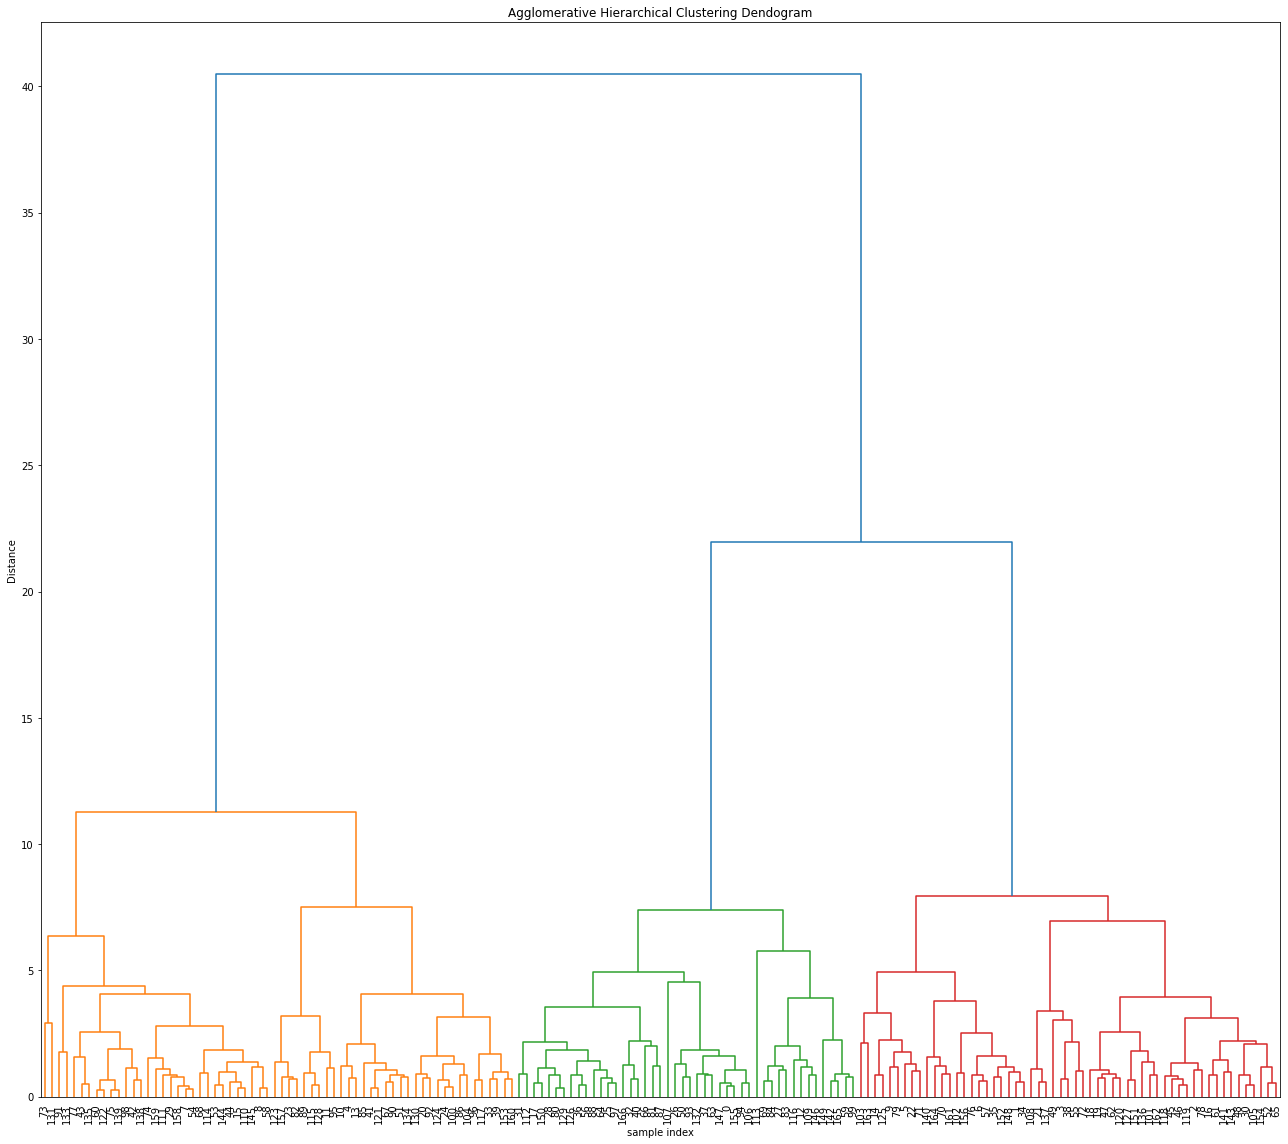

In [56]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
Z = linkage(X, 'ward')
dendrogram(Z,leaf_rotation=90.0,p=25,color_threshold=15,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()